In [120]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels import tsa

## Helpful visuals
<img src='acpacf.jpg'>
---
<img src = 'acfint.png'>
---

<img src='adv.png'>

In [252]:
# importing the dataset
data = pd.read_csv('../../data/air_passengers.csv',usecols=[0,1],parse_dates=[0],date_format='%Y-%m',index_col=0)
data.head()

,Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


In [152]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 144 entries, 1949-01-01 to 1960-12-01
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   Passengers  144 non-null    int64
dtypes: int64(1)
memory usage: 2.2 KB


In [158]:
# timeframe of the data
data.index.year.unique()

Index([1949, 1950, 1951, 1952, 1953, 1954, 1955, 1956, 1957, 1958, 1959, 1960], dtype='int32', name='Month')

In [160]:
data.isnull().sum()
# no nulls, but will use bfill/ffill, or median imputer to remedy this

Passengers    0
dtype: int64

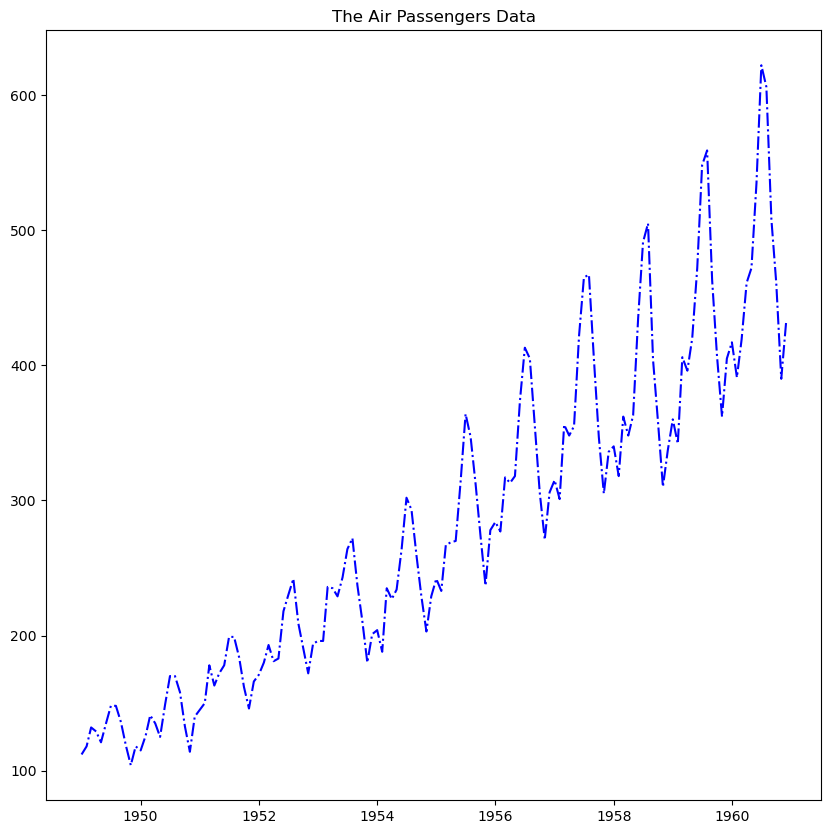

In [162]:
# plotting the data
plt.subplots(figsize=(10,10))
plt.plot(data.index,data.Passengers,'b-.')
plt.title('The Air Passengers Data')
plt.show()

#or use
# data.plot('Month','Passengers')

## Stop

#### Is the data stationary?
* For data to be stationary, by the WSS requirements,
  - constant mean
  - constant variance
  - auto-covariance that is only a function of lag
  - These statistical properties of the process shouldn't change over time for it to be stationary
 
#### How do we test for Stationarity
* The Ad-Fuller test (Augmented Dickey-Fuller test)
* KPSS test (Kwiatkowski-Philips-Schimdt-Shin test)

---
Time series with trends or seasonality are *not* stationary

---

We will now use the Ad-Fuller test to check for stationarity

In [94]:
# using the time series functions in statsmodels (Ad-Fuller)
res = tsa.stattools.adfuller(data.Passengers)

print(f'The Ad-Fuller statistic is: {res[0]}\nThe p-value of the test is: {res[1]}\nThe used lag is {res[2]}\nThe Critical Values are:\n')
for key, val in res[4].items():
    print(f'{key},{val}\n')

if res[1]>.05:
    print('not stationary')
else:
    print('stationary')

The Ad-Fuller statistic is: 0.8153688792060547
The p-value of the test is: 0.9918802434376411
The used lag is 13
The Critical Values are:

1%,-3.4816817173418295

5%,-2.8840418343195267

10%,-2.578770059171598

not stationary


### NOTE
* For the Ad-Fuller test, having a p-value less than 0.05 is strong indicator of stationarity
  - $H_0$- series is non-stationary
  - $H_1$- series is stationary
* For the KPSS test, having a p-value greater than 0.05 is strong indicator of stationarity
  - $H_0$- series is stationary
  - $H_1$- series is non-stationary

In [96]:
# using the time series functions in statsmodels (KPSS)
stat, p, lag, critvals= tsa.stattools.kpss(data.Passengers)

print(f'The KPSS statistic is: {stat}\nThe p-value of the test is: {p}\nThe used lag is {lag}\nThe Critical Values are:\n')
for key, val in critvals.items():
    print(f'{key}: {val}\n')

if p>.05:
    print('stationary')
else:
    print('not stationary')

The KPSS statistic is: 1.6513122354165206
The p-value of the test is: 0.01
The used lag is 8
The Critical Values are:

10%: 0.347

5%: 0.463

2.5%: 0.574

1%: 0.739

not stationary


C:\Users\ferdy\AppData\Local\Temp\ipykernel_32652\641591361.py:2: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  stat, p, lag, critvals= tsa.stattools.kpss(data.Passengers)


## Interpreting the results of the test
* Ad-Fuller Test
  - The p-value is well above the given threshold of $\alpha=.05$, hence we fail to reject the Null Hypothesis
  - $\therefore$ the series is non-stationary
* KPSS test
  - The p-value is well below the given threshold of $\alpha=.05$, hence we may reject the null hypothesis
  - $\therefore$ the series is non-stationary

## Dealing with Trend and Seasonality

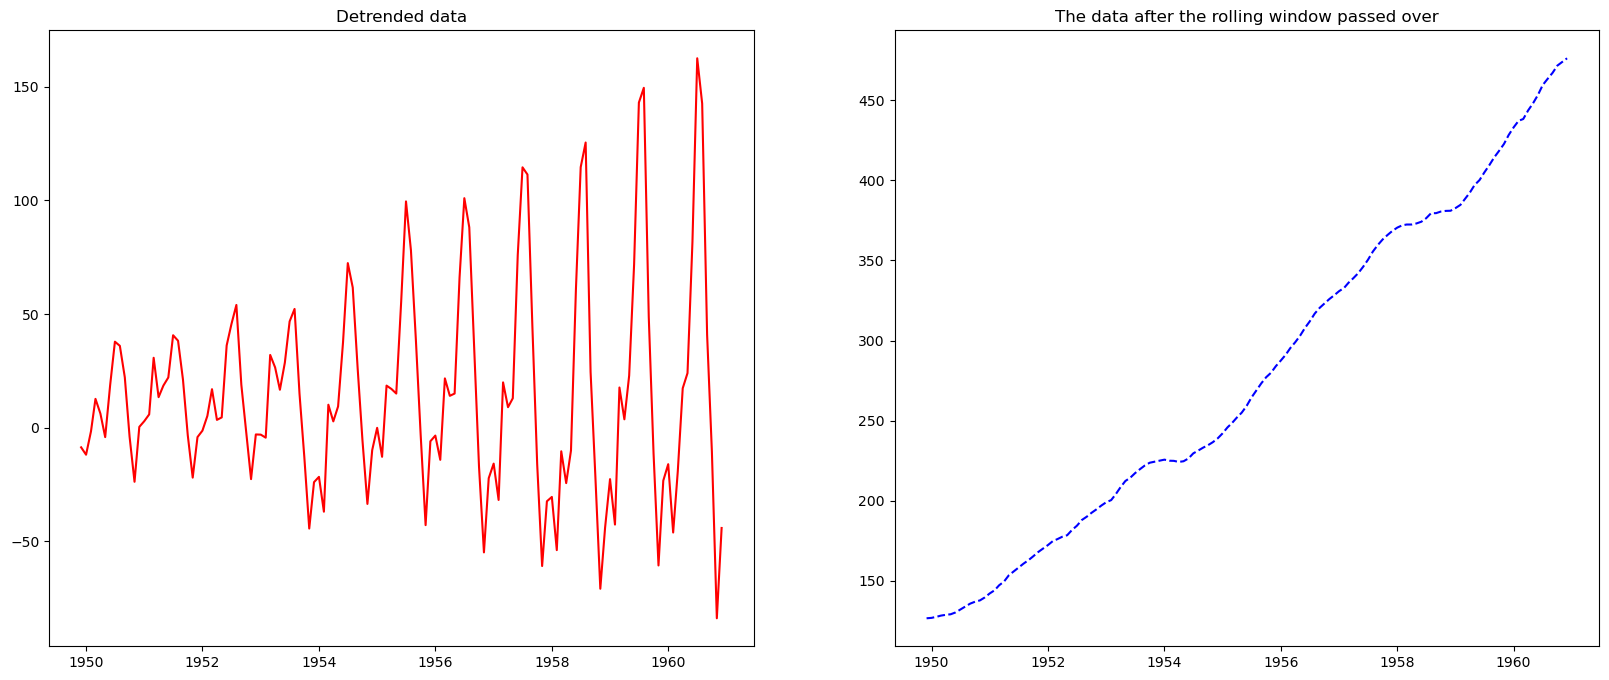

In [254]:
# Since trend is a pattern of broad increases/decreases in the data,
# We can remove trend with rolling mean differencing
# here the rolling mean is a moving average (a window that moves over the dataset)
# the window itself will be in months, as this is yearly data

rm = data.Passengers.rolling(window=12).mean()

# this creates a rolling window with a specified size and 
# performs calculations over the specified 'window'
# this window passes over the data, generating a mirror series of rolling-means

# They are useful for finding long-term trends disguised by random fluctuations

data_detrended = data.Passengers.astype('float64') - rm

plt.subplots(1,2,figsize=(20,8))
plt.subplot(121)
plt.plot(data.index,data_detrended,ls='-',c='r')
plt.title('Detrended data')

plt.subplot(122)
plt.plot(data.index,rm,ls='--',c='b')
plt.title('The data after the rolling window passed over')

plt.show()

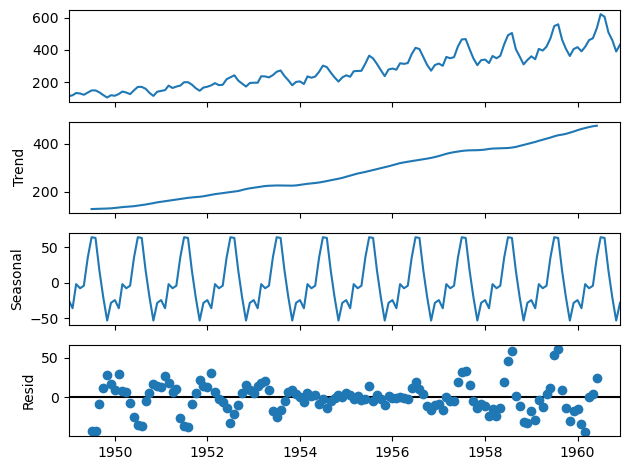

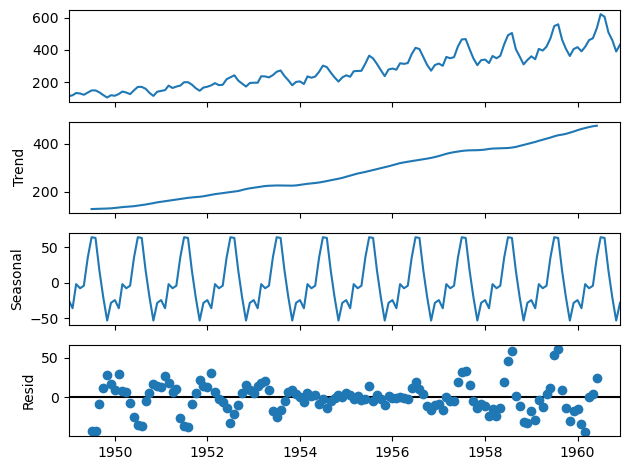

In [180]:
# removing seasonality with seasonal decompose
decomp = statsmodels.tsa.seasonal.seasonal_decompose(data)

decomp.plot()

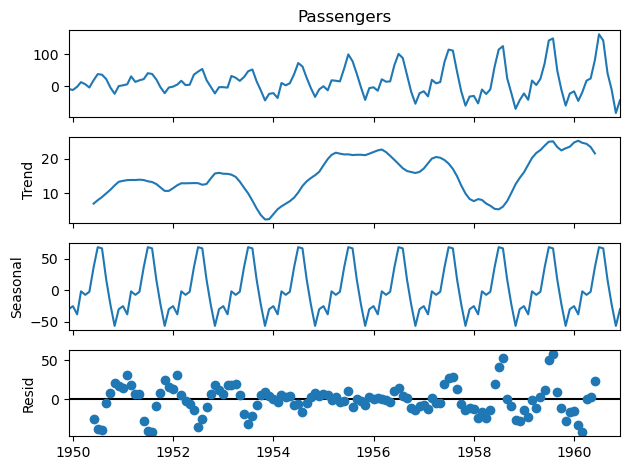

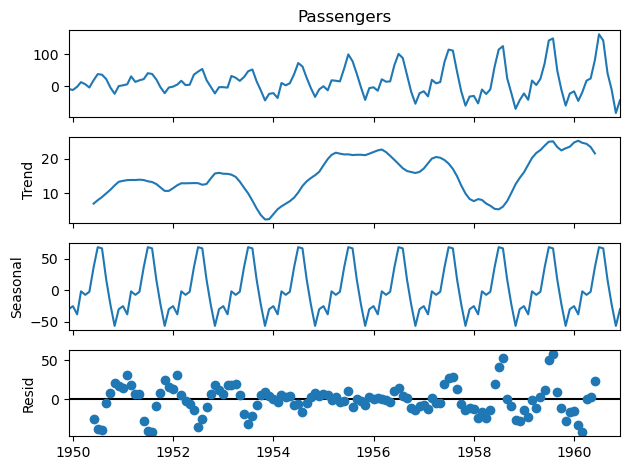

In [188]:
decomp2 = tsa.seasonal.seasonal_decompose(data_detrended.dropna())

decomp2.plot()

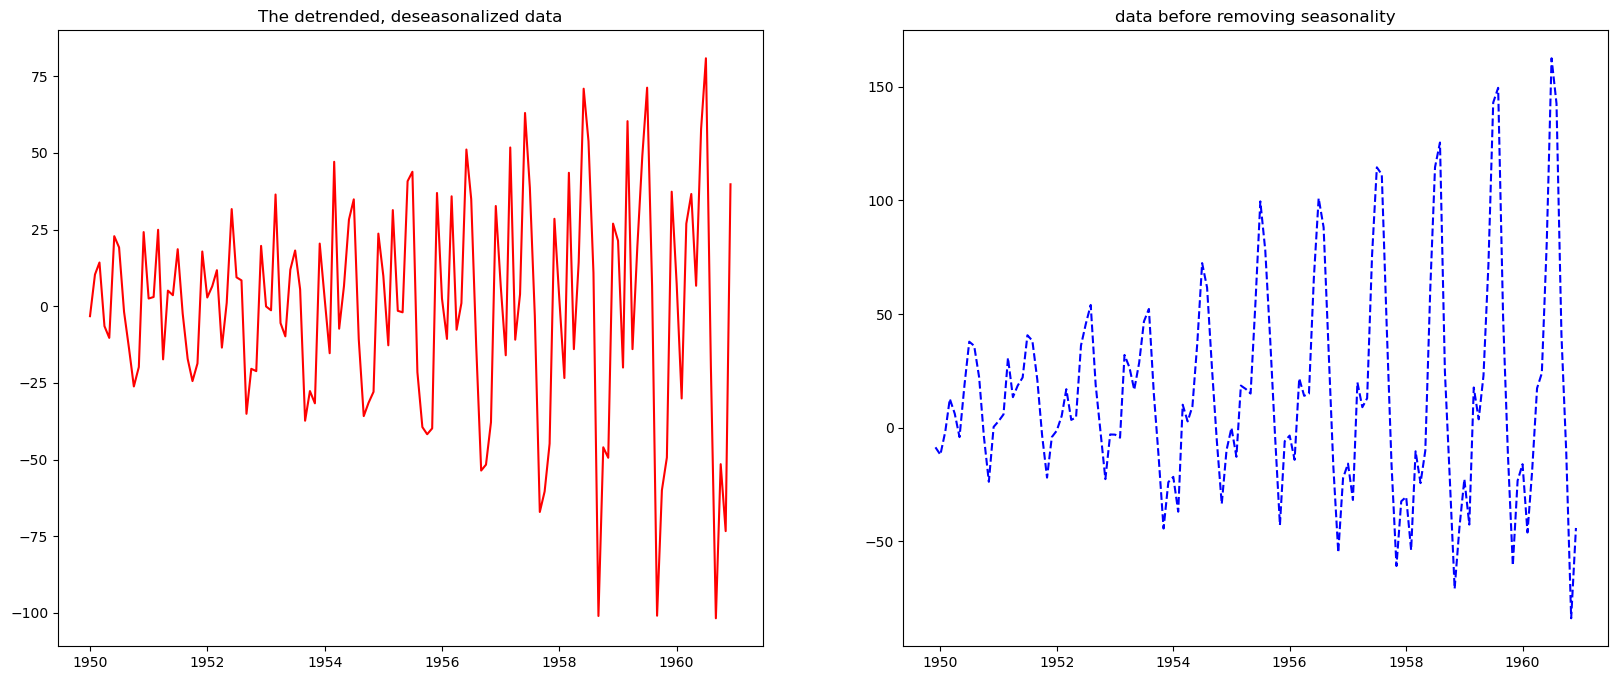

In [256]:
# removing Seasonality from the time-series
# we will use the shift() or the diff() operator to do this
rm_detrended_diff1 = data_detrended.diff(1)

plt.subplots(1,2,figsize=(20,8))
plt.subplot(121)
plt.plot(data.index,rm_detrended_diff1,ls='-',c='r')
plt.title('The detrended, deseasonalized data')

plt.subplot(122)
plt.plot(data.index,data_detrended.values,ls='--',c='b')
plt.title('data before removing seasonality')
plt.show()


In [258]:
rmdd = rm_detrended_diff1.dropna()

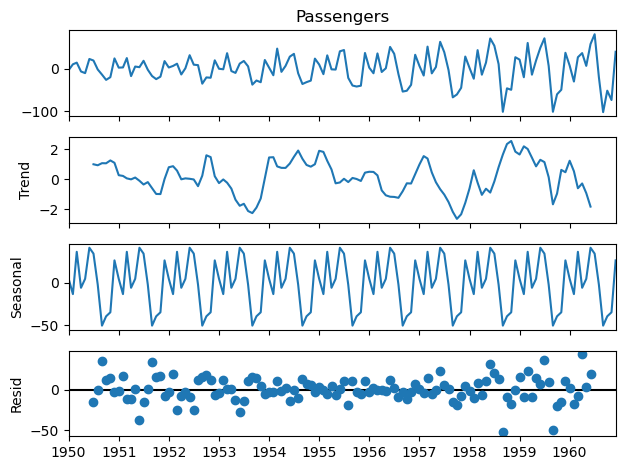

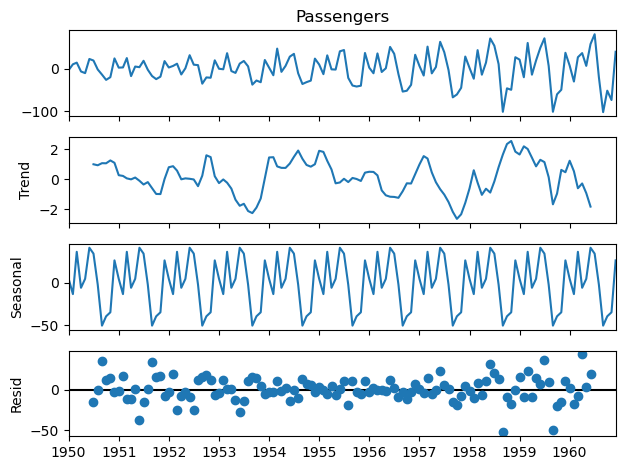

In [210]:
# Let's apply seasonal decompose once more on the detrended, deseasonalized data to see the difference
decomp3 = tsa.seasonal.seasonal_decompose(rmdd)

decomp3.plot()

## Retesting with Ad-fuller and KPSS

In [215]:
# using the time series functions in statsmodels (Ad-Fuller)
res2 = tsa.stattools.adfuller(rmdd)

print(f'The Ad-Fuller statistic is: {res2[0]}\nThe p-value of the test is: {res2[1]}\nThe used lag is {res2[2]}\nThe Critical Values are:\n')
for key, val in res2[4].items():
    print(f'{key},{val}\n')

if res2[1]>.05:
    print('not stationary')
else:
    print('stationary')

The Ad-Fuller statistic is: -3.1544826348635393
The p-value of the test is: 0.02277526496786156
The used lag is 12
The Critical Values are:

1%,-3.4865346059036564

5%,-2.8861509858476264

10%,-2.579896092790057

stationary


In [221]:
# using the time series functions in statsmodels (KPSS)
stat2, p2, lag2, critvals2= tsa.stattools.kpss(rmdd)

print(f'The KPSS statistic is: {stat2}\nThe p-value of the test is: {p2}\nThe used lag is {lag2}\nThe Critical Values are:\n')
for key, val in critvals2.items():
    print(f'{key}: {val}\n')

if p2>.05:
    print('stationary')
else:
    print('not stationary')

The KPSS statistic is: 0.019275033111782067
The p-value of the test is: 0.1
The used lag is 1
The Critical Values are:

10%: 0.347

5%: 0.463

2.5%: 0.574

1%: 0.739

stationary


C:\Users\ferdy\AppData\Local\Temp\ipykernel_32652\3826420656.py:2: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  stat2, p2, lag2, critvals2= tsa.stattools.kpss(rmdd)


## Outcomes of the tests
* We can see that both tests are in agreement, that the detrended and deseasonalized data is stationary

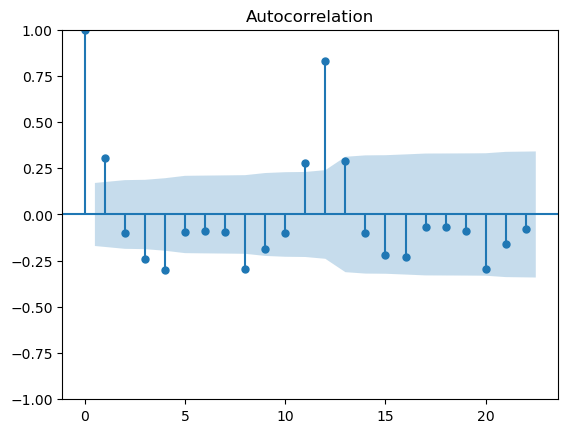

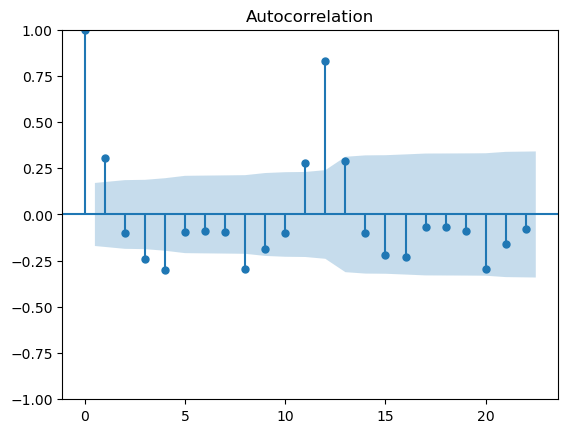

In [228]:
from pandas.plotting import autocorrelation_plot
from statsmodels.graphics.tsaplots import plot_acf

# to check for the stationarity of the time series
# statsmodels provided a plot_acf function to plot the ACF plot
plot_acf(rmdd.values)

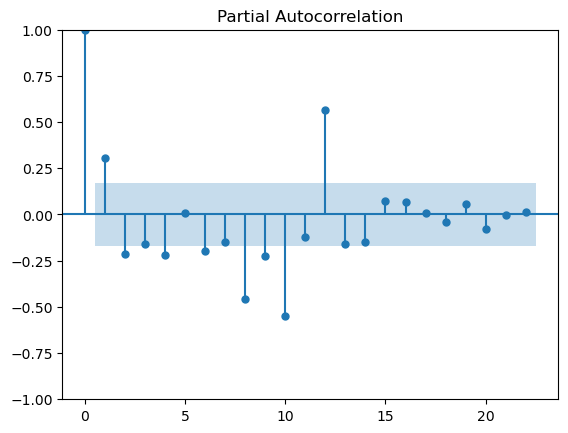

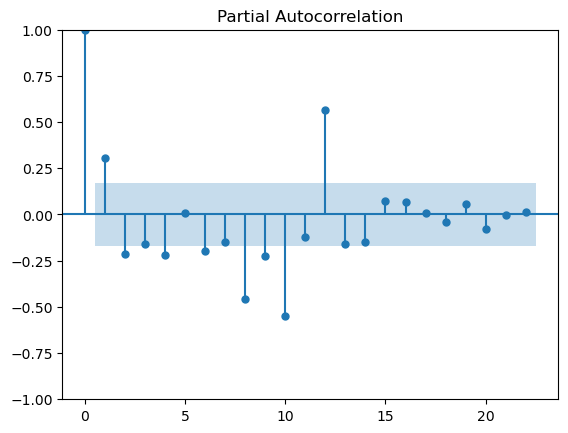

In [230]:
# we will now plot the pacf values
from statsmodels.graphics.tsaplots import plot_pacf

plot_pacf(rmdd)

In [234]:
# we will now use the ARIMA model on the data
from pmdarima import auto_arima

order = auto_arima(rmdd,trace=True)
order.summary()

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.57 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=1314.475, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=1303.387, Time=0.04 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=1298.888, Time=0.06 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=1312.483, Time=0.03 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=1295.760, Time=0.16 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.10 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.18 sec
 ARIMA(0,0,2)(0,0,0)[0] intercept   : AIC=1297.960, Time=0.08 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=1298.290, Time=0.05 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=1293.760, Time=0.05 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=1296.888, Time=0.03 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=1301.389, Time=0.04 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=inf, Time=0.13 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=inf, Time=0

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  132
Model:               SARIMAX(3, 0, 3)   Log Likelihood                -610.892
Date:                Fri, 21 Jun 2024   AIC                           1235.785
Time:                        20:48:00   BIC                           1255.964
Sample:                    01-01-1950   HQIC                          1243.985
                         - 12-01-1960                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8644      0.162      5.346      0.000       0.548       1.181
ar.L2          0.2042      0.230      0.889      0.374      -0.246       0.654
ar.L3         -0.5267      0.140     -3.773      0.000      -0.800      -0.253
ma.L1         -0.9137      0.128     -7.154      0.000      -1.164      -0.663
ma.L2         -0.8209      0.168     -4.884      0.000      -1.150      -0.491
ma.L3          0.7468      0.095      7.850      0.000       0.560       0.933
sigma2       586.1902     67.804      8.645      0.000     453.297     719.083
===================================================================================
Ljung-Box (L1) (Q):                   0.13   Jarque-Bera (JB):                 2.56
Prob(Q):                              0.72   Prob(JB):                         0.28
Heteroskedasticity (H):               6.24   Skew:                             0.28
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.38
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [240]:
# we will not do the same using the statsmodels's ARIMA
from statsmodels.tsa.arima.model import ARIMA

train = rmdd.iloc[:120]
test = rmdd.iloc[121:]

#ARIMA
# We have found the best model parameters to be:
# AR(p) = 3
# I(d) = 0
# MA(q) = 3

model = ARIMA(train,order=(3,0,3))
model_fit = model.fit() #fitting the data
model_fit.summary()

C:\Users\ferdy\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\ferdy\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\ferdy\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\ferdy\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\ferdy\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA param

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:             Passengers   No. Observations:                  120
Model:                 ARIMA(3, 0, 3)   Log Likelihood                -546.713
Date:                Fri, 21 Jun 2024   AIC                           1109.427
Time:                        20:52:22   BIC                           1131.727
Sample:                    01-01-1950   HQIC                          1118.483
                         - 12-01-1959                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0651      0.040      1.630      0.103      -0.013       0.143
ar.L1          0.7922      0.116      6.836      0.000       0.565       1.019
ar.L2          0.3299      0.133      2.481      0.013       0.069       0.591
ar.L3         -0.5813      0.077     -7.571      0.000      -0.732      -0.431
ma.L1         -0.8686      2.615     -0.332      0.740      -5.993       4.256
ma.L2         -0.9993      2.319     -0.431      0.667      -5.545       3.546
ma.L3          0.8680      2.773      0.313      0.754      -4.567       6.303
sigma2       484.3387   1617.349      0.299      0.765   -2685.608    3654.285
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                 0.17
Prob(Q):                              0.98   Prob(JB):                         0.92
Heteroskedasticity (H):               5.91   Skew:                             0.05
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.16
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [260]:
predict = model_fit.predict(start=len(train),end=len(train)+len(test)-1,dynamic=True)

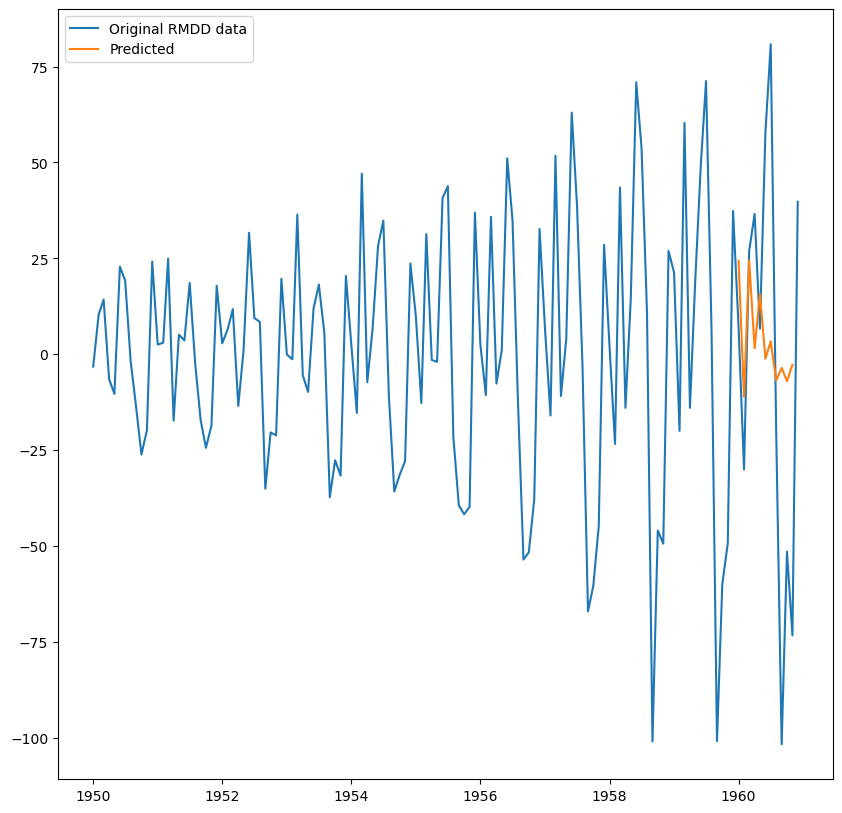

In [266]:
plt.subplots(figsize=(10,10))
plt.plot(rmdd,label='Original RMDD data')
plt.plot(predict,label='Predicted')
plt.legend()
plt.show()

In [274]:
from statsmodels.tsa.statespace.sarimax import SARIMAX, SARIMAXResults

model = SARIMAX(train, order=(3,0,3),seasonal_order=(3,0,3,12),enforce_stationarity=False)
model = model.fit()

C:\Users\ferdy\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\ferdy\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\ferdy\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\ferdy\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
C:\Users\ferdy\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood 

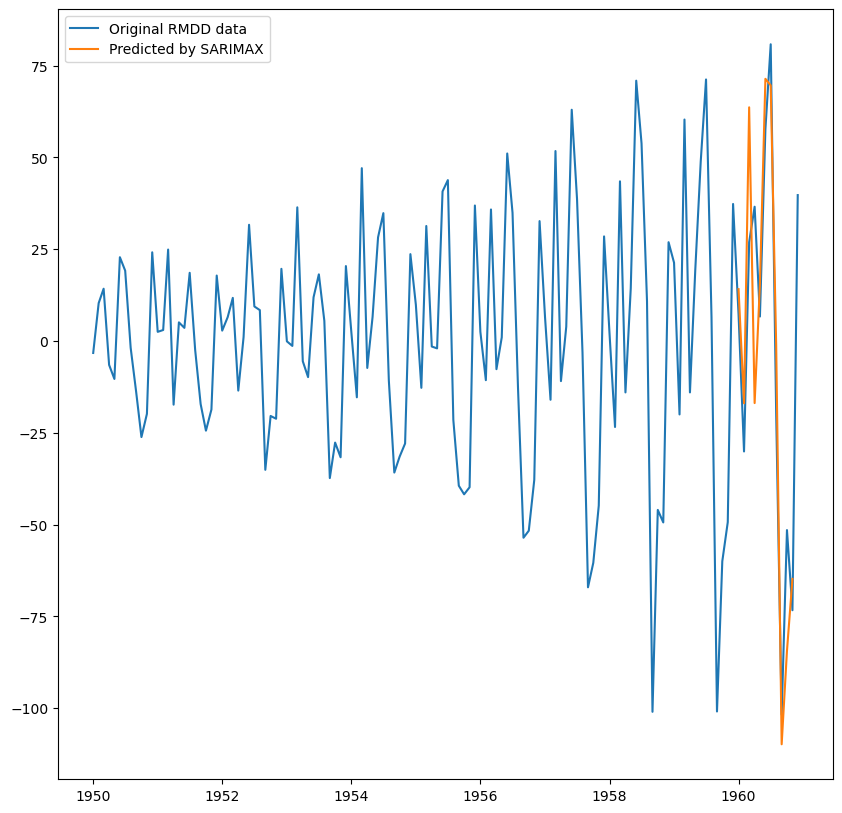

In [276]:
predicted2 = model.predict(start=len(train),end=len(train)+len(test)-1,dynamic=True)

plt.subplots(figsize=(10,10))
plt.plot(rmdd,label='Original RMDD data')
plt.plot(predicted2,label='Predicted by SARIMAX')
plt.legend()
plt.show()

C:\Users\ferdy\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\kalman_filter.py:2473: ValueWarning: Dynamic prediction specified to begin during out-of-sample forecasting period, and so has no effect.
  warn('Dynamic prediction specified to begin during'


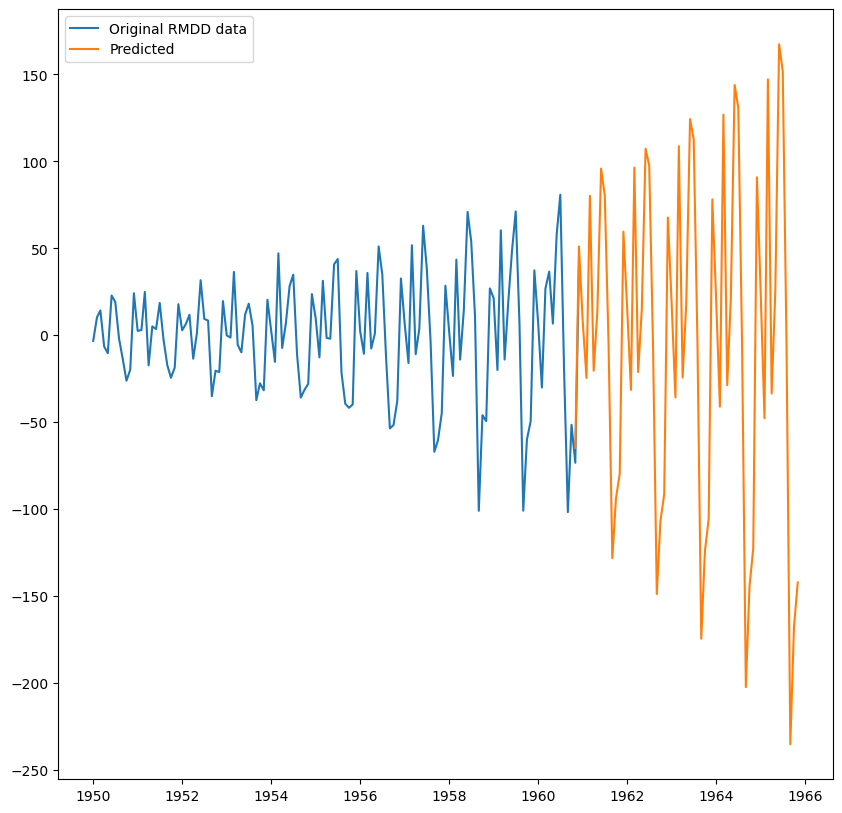

In [278]:
# say we now wish to predict 5 years into the future
predicted3 = model.predict(start=len(train)+len(test)-1,end=len(train)+len(test)-1+60,dynamic=True)

plt.subplots(figsize=(10,10))
plt.plot(rmdd,label='Original RMDD data')
plt.plot(predicted3,label='Predicted')
plt.legend()
plt.show()